In [70]:
import sys
sys.path.append('../')

from util.mongodb_util import create_mongodb_connection, mongodb_to_df

df_from_db = mongodb_to_df(100000)
df = df_from_db.drop(columns=['_id'])
print(df_from_db.head())

                        _id  index                       hotel_name  \
0  5ffd648c6fb44d5f602ea1be      0  \nTower Suites by Blue Orchid\n   
1  5ffd648c6fb44d5f602ea1bf      1  \nTower Suites by Blue Orchid\n   
2  5ffd648c6fb44d5f602ea1c0      2  \nTower Suites by Blue Orchid\n   
3  5ffd648c6fb44d5f602ea1c1      3  \nTower Suites by Blue Orchid\n   
4  5ffd648c6fb44d5f602ea1c2      4  \nTower Suites by Blue Orchid\n   

               nation                                             review  \
0        \n\nMalaysia         everything absolutely beautiful clean love   
1        \n\nMalaysia                       couldnt get room comfortable   
2  \n\nUnited Kingdom  felt clean new lovely staff room really spacio...   
3  \n\nUnited Kingdom  breakfast nice friendly helpful staff restaura...   
4  \n\nUnited Kingdom      smoking area floor pay full english breakfast   

   is_positive  score  
0            1   10.0  
1            0   10.0  
2            1    9.0  
3            1    9.

In [73]:
from dask.distributed import Client, progress
# client = Client(n_workers=2, threads_per_worker=2, memory='2GB')
client= Client()
client


/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51250 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:51251 Dashboard: http://127.0.0.1:51250/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [74]:
# Create dask dataframe from pandas
# Split dataframe
import dask.dataframe as dd
dask_df = dd.from_pandas(df, npartitions=4)



In [75]:

X = dask_df['review'].values
ylabels = dask_df['is_positive'].values


In [76]:
print(type(X))
print(type(X.compute()))

<class 'dask.array.core.Array'>
<class 'numpy.ndarray'>


In [77]:
X = X.compute()
ylabels = ylabels.compute()

In [78]:
print(type(ylabels))
print(ylabels.shape)
print(ylabels)

<class 'numpy.ndarray'>
(100000,)
[1 0 1 ... 0 1 0]


In [79]:
from dask_ml.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=5)


In [80]:
print(y_train.shape)
print(x_train.shape)

(80000,)
(80000,)


In [81]:
import dask.bag as db
x_train = db.from_sequence(x_train, npartitions=2)
x_test = db.from_sequence(x_test, npartitions=2)

In [82]:
print(x_train)
print(type(y_train))
print(y_train.shape)

dask.bag<from_sequence, npartitions=2>
<class 'numpy.ndarray'>
(80000,)


In [83]:
import dask_ml.feature_extraction.text
vect = dask_ml.feature_extraction.text.HashingVectorizer(n_features=1000, ngram_range=(1,2))
from dask_ml.feature_extraction.text import CountVectorizer
vect2 = CountVectorizer()
# train = vect.fit_transform(x_train)
# train

In [84]:
# train.compute()
# train.compute_chunk_sizes()

In [85]:
# Build Model

import sklearn.pipeline as ppl


# model = ppl.Pipeline([("vectorizer", vect), ("classifier", classifier)])
pipeline = ppl.Pipeline([("vectorizer", vect)])
pipeline_model_train = pipeline.fit(x_train)
pipeline_model_test = pipeline.fit(x_test)
pipeline_model_train
pipeline_model_test

Pipeline(steps=[('vectorizer',
                 HashingVectorizer(n_features=1000, ngram_range=(1, 2)))])

In [86]:
# Train Model
# %time
# train_model = model.fit(train, y_train)

# pipeline_model.shape

In [87]:
import pickle
text_preprocess_pipe_train = pickle.dumps(pipeline_model_train)
text_preprocess_pipe_test = pickle.dumps(pipeline_model_test)

In [88]:
pipeline_model_train = pickle.loads(text_preprocess_pipe_train)
pipeline_model_test = pickle.loads(text_preprocess_pipe_test)

In [89]:
%time
x_train_transformed = pipeline_model_train.transform(x_train)
x_test_transformed = pipeline_model_test.transform(x_test)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [90]:
print(x_train_transformed.shape)
print(x_test_transformed.shape)

(nan, 1000)
(nan, 1000)


In [91]:
transformed_x_train  = x_train_transformed.compute()
transformed_x_test  = x_test_transformed.compute()



In [92]:
print(transformed_x_train.shape)
print(transformed_x_test.shape)

(80000, 1000)
(20000, 1000)


In [93]:
print(y_train.shape)
print(y_train)
print(y_test.shape)
print(y_test)

(80000,)
[0 1 1 ... 0 1 0]
(20000,)
[0 1 1 ... 0 1 0]


In [103]:
%%time
import joblib
from dask_ml.linear_model import LogisticRegression

# classifier = LogisticRegression()
# x_train_transformed.compute_chunk_sizes()

classifier = LogisticRegression(fit_intercept=False)
with joblib.parallel_backend('dask'):
    model = classifier.fit(transformed_x_train.toarray(), y_train)

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


CPU times: user 15.3 s, sys: 9.04 s, total: 24.3 s
Wall time: 1min 14s


In [99]:
%%time
predictions = model.predict(transformed_x_test.toarray())
predictions

CPU times: user 92.1 ms, sys: 62.9 ms, total: 155 ms
Wall time: 149 ms


array([False,  True,  True, ..., False,  True, False])

In [96]:
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, predictions)
recall = metrics.recall_score(y_test, predictions)
precision = metrics.precision_score(y_test, predictions)
f1_score = 2 * (precision * recall) / (precision + recall)
auc = metrics.roc_auc_score(y_test, predictions, multi_class="ovr")

cm = metrics.confusion_matrix(y_test, predictions)
                            
print(f"Accuracy: {accuracy} | Precision: {precision} | Recall: {recall}")
print(f"F1 score: {f1_score}")
print(f"AUC: {auc}")

Accuracy: 0.88425 | Precision: 0.8923436688030487 | Recall: 0.9057582417582417
F1 score: 0.8990009161903932
AUC: 0.8808211498646281


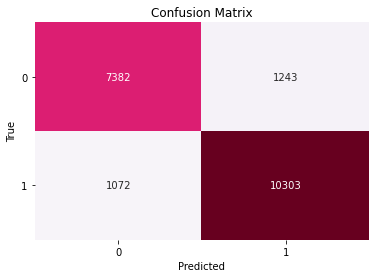

In [97]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

classes = [0, 1]
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.PuRd, cbar=False)
ax.set(xlabel="Predicted",
       ylabel="True",
       xticklabels=classes,
       yticklabels=classes,
       title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()

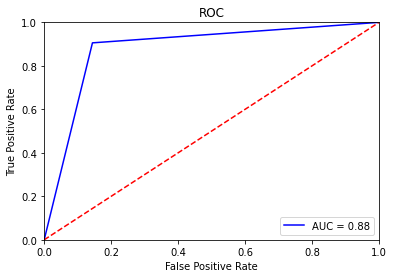

In [98]:
# plot roc curve

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()